to device: cuda
Epoch    0 train: loss 2.3179 - acc 0.0993
Epoch    0 test: loss 2.2832 - acc 0.1294
Epoch    1 train: loss 2.2838 - acc 0.1242
Epoch    1 test: loss 2.2377 - acc 0.2969
Epoch    2 train: loss 2.2392 - acc 0.2895
Epoch    2 test: loss 2.1996 - acc 0.2991
Epoch    3 train: loss 2.2014 - acc 0.2893
Epoch    3 test: loss 2.1750 - acc 0.3242
Epoch    4 train: loss 2.1766 - acc 0.3178
Epoch    4 test: loss 2.1557 - acc 0.3801
Epoch    5 train: loss 2.1573 - acc 0.3673
Epoch    5 test: loss 2.1417 - acc 0.4266
Epoch    6 train: loss 2.1432 - acc 0.4058
Epoch    6 test: loss 2.1290 - acc 0.4294
Epoch    7 train: loss 2.1304 - acc 0.4147
Epoch    7 test: loss 2.1173 - acc 0.4340
Epoch    8 train: loss 2.1184 - acc 0.4213
Epoch    8 test: loss 2.1065 - acc 0.4460
Epoch    9 train: loss 2.1078 - acc 0.4345
Epoch    9 test: loss 2.0946 - acc 0.4487
Epoch   10 train: loss 2.0963 - acc 0.4371
Epoch   10 test: loss 2.0840 - acc 0.4577
Epoch   11 train: loss 2.0859 - acc 0.4450
Epoch 

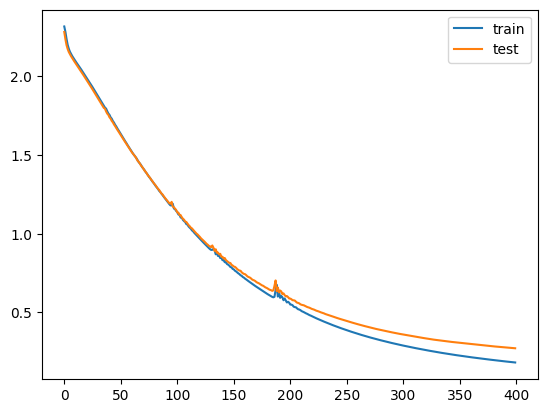

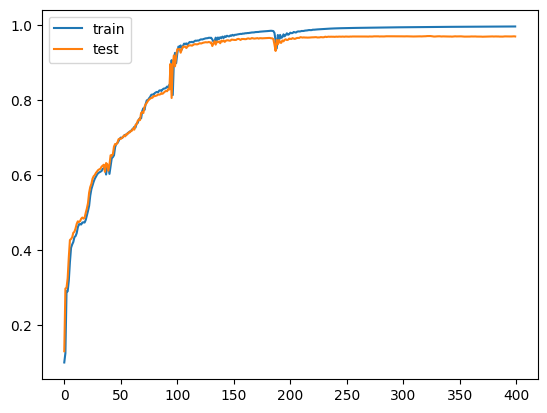

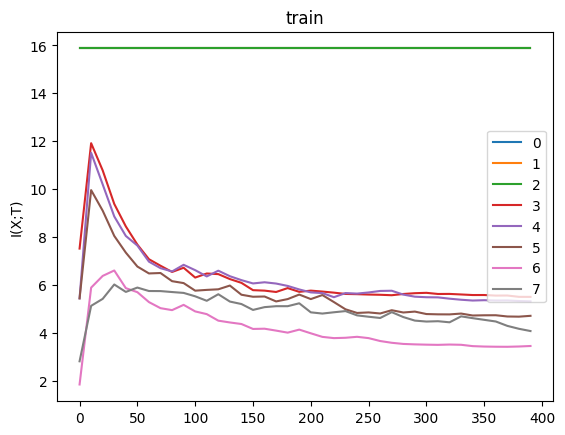

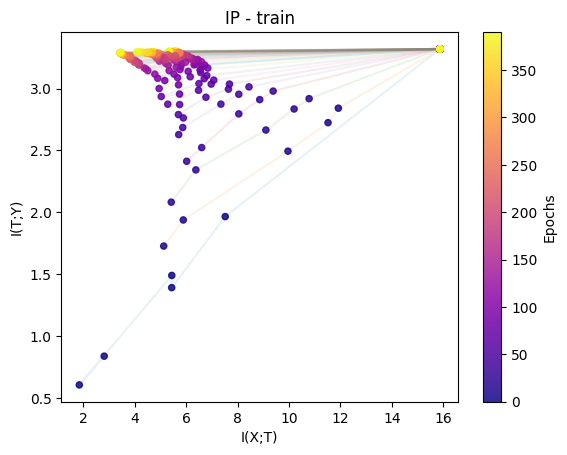

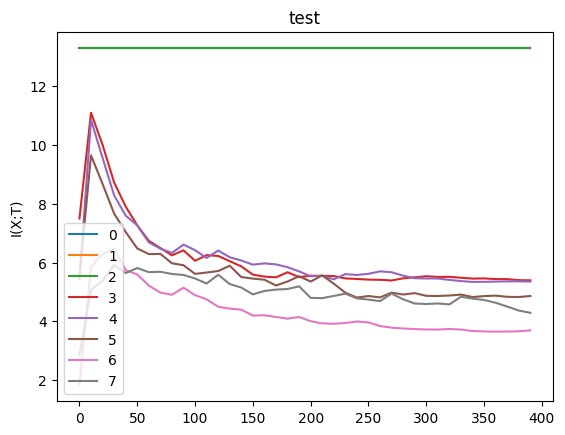

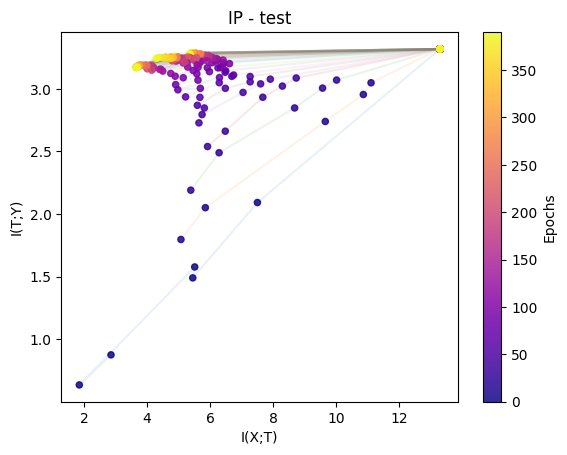

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
from random import seed
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
import simplebinmi

# 设置随机种子
np.random.seed(1234)
seed(1234)
torch.manual_seed(1234)
def get_unique_probs(x):
    uniqueids = np.ascontiguousarray(x).view(np.dtype((np.void, x.dtype.itemsize * x.shape[1])))
    _, unique_inverse, unique_counts = np.unique(uniqueids, return_index=False, return_inverse=True, return_counts=True)
    return np.asarray(unique_counts / float(sum(unique_counts))), unique_inverse


def bin_calc_information(labelixs, layerdata, binsize):
    # This is even further simplified, where we use np.floor instead of digitize
    nats2bits = 1.0 / np.log(2)

    def get_h(d):
        digitized = np.floor(d / binsize).astype('int')
        p_ts, _ = get_unique_probs( digitized )
        return -np.sum(p_ts * np.log(p_ts))

    H_LAYER = get_h(layerdata)
    H_LAYER_GIVEN_OUTPUT = 0
    for label, ixs in labelixs.items():
        h = get_h(layerdata[ixs])
        H_LAYER_GIVEN_OUTPUT += ixs.mean() * h
    return nats2bits * H_LAYER, nats2bits * (H_LAYER - H_LAYER_GIVEN_OUTPUT)
    
# 定义 MNIST 数据集类
class MNIST(datasets.MNIST):
    def __init__(self, root, train=True, download=False, randomize=False):
        super(MNIST, self).__init__(root, train, download)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.targets = self.targets.to(device)
        self.data = self.data / 255.0
        self.data = self.data.view(-1, 28 * 28).to(device)

        if randomize:
            idx_rnd = torch.randperm(len(self.targets))
            self.targets = self.targets[idx_rnd]

    def __getitem__(self, index):
        img, targets = self.data[index], self.targets[index]
        return img, targets

# 定义 FeedForward 神经网络
class FeedForward(torch.nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FeedForward, self).__init__()
        torch.manual_seed(1234)
        self.hidden_sizes = hidden_sizes
        self.layers = torch.nn.ModuleList()
        hidden_sizes += [output_size]
        self.n_layers = len(hidden_sizes)
        prev = input_size
        for h in hidden_sizes:
            self.layers.append(torch.nn.Linear(prev, h))
            prev = h

    def forward(self, x):
        hiddens = []
        for j, layer in enumerate(self.layers):
            if j != (self.n_layers - 1):
                x = torch.tanh(layer(x))
                hiddens.append(x)
            else:
                x = layer(x)
                hiddens.append(x)
        return x, hiddens

# 定义训练和测试函数
def run_training(model, criterion, optimizer, loader, epochs=5000, mi_cycle=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    losses = {'train': [], 'test': []}
    accuracy = {'train': [], 'test': []}
    running_mis_xt = {'train': [], 'test': []}
    running_mis_ty = {'train': [], 'test': []}

    def get_class_masks(loader):
        samples_split = dict()
        for phase in ['train', 'test']:
            samples_split[phase] = {}
            classes = loader[phase].dataset.targets.cpu().detach().numpy()
            for i in range(10):
                samples_split[phase][i] = classes == i
        return samples_split

    class_masks = get_class_masks(loader)
    n_layers = model.n_layers

    for i in range(epochs):
        for phase in ['train', 'test']:
            phase_loss = 0.0
            phase_labels = torch.tensor([], dtype=torch.long).to(device)
            phase_outputs = torch.tensor([]).to(device)

            for inputs, labels in loader[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs, hiddens = model(inputs)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                phase_loss += loss.item()
                phase_labels = torch.cat((phase_labels, labels))
                phase_outputs = torch.cat((phase_outputs, outputs))

            if i % mi_cycle == 0:
                running_mis_xt[phase].append([])
                running_mis_ty[phase].append([])
                _, hiddens = model(loader[phase].dataset.data.to(device))
                for j in range(n_layers):
                    activity = hiddens[j].cpu().detach().numpy()
                    binxm, binym = bin_calc_information(class_masks[phase], activity,binsize=0.5)
                    running_mis_xt[phase][-1].append(binxm)
                    running_mis_ty[phase][-1].append(binym)

            n = float(len(loader[phase].dataset))
            loss = phase_loss / n
            acc = (phase_labels == phase_outputs.argmax(dim=1)).sum() / n
            accuracy[phase].append(float(acc))

            losses[phase].append(loss)
            print(f'Epoch {i:>4} {phase}: loss {loss:>.4f} - acc {acc:>.4f}')

    # 保存训练结果
    tracking = {
        'n_layers': n_layers,
        'mi_cycle': mi_cycle,
        'losses': losses,
        'accuracy': accuracy,
        'running_mis_xt': running_mis_xt,
        'running_mis_ty': running_mis_ty,
    }
    with open('train.pkl', 'wb') as f:
        pickle.dump(tracking, f)

    return tracking

# 绘图函数
def plot_results(tracking):
    def format_epochs(x, pos):
        return int(x * tracking['mi_cycle'])

    # 绘制损失
    plt.figure()
    for phase in ['train', 'test']:
        plt.plot(tracking['losses'][phase], label=phase)
    plt.legend()
    plt.savefig('losses.png')
    plt.show()

    # 绘制准确率
    plt.figure()
    for phase in ['train', 'test']:
        plt.plot(tracking['accuracy'][phase], label=phase)
    plt.legend()
    plt.savefig('acc.png')
    plt.show()

    # 绘制信息平面
    for phase in ['train', 'test']:
        running_mis_xt = np.array(tracking['running_mis_xt'][phase])
        running_mis_ty = np.array(tracking['running_mis_ty'][phase])

        fig, ax = plt.subplots()
        plt.title(phase)
        for i in range(tracking['n_layers']):
            plt.plot(running_mis_xt[:, i], label=f'{i}')
        plt.legend()
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_epochs))
        plt.ylabel('I(X;T)')
        plt.savefig(f'plot_{phase}.png')
        plt.show()

        plt.figure()
        plt.title(f'IP - {phase}')
        c = list(range(len(running_mis_xt[:, 0])))
        for j in range(tracking['n_layers']):
            plt.scatter(running_mis_xt[:, j], running_mis_ty[:, j], c=c, cmap='plasma', s=20, alpha=0.85, zorder=1)
        for j in range(len(running_mis_xt[:, 0])):
            plt.plot(running_mis_xt[j, :], running_mis_ty[j, :], alpha=0.1, zorder=0)

        cbar = plt.colorbar(format=ticker.FuncFormatter(format_epochs))
        cbar.set_label('Epochs')

        plt.xlabel('I(X;T)')
        plt.ylabel('I(T;Y)')
        plt.savefig(f'IP_{phase}.png')
        plt.show()

# 数据准备
data = dict()
data['train'] = MNIST('./dataset', train=True, download=True, randomize=False)
data['test'] = MNIST('./dataset', train=False)

loader = dict()
loader['train'] = DataLoader(data['train'], batch_size=60000, shuffle=False)
loader['test'] = DataLoader(data['test'], batch_size=10000, shuffle=False)

# 配置和训练
input_size = 28 * 28
output_size = 10
hidden_sizes = [784, 1024, 1024, 20, 20, 20, 10]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'to device: {device}')
net = FeedForward(input_size, hidden_sizes, output_size).to(device)

criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# 运行训练和测试
tracking = run_training(net, criterion, optimizer, loader, epochs=400, mi_cycle=10)

# 绘图
plot_results(tracking)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:03<00:00, 2888162.48it/s]


Extracting ./dataset\MNIST\raw\train-images-idx3-ubyte.gz to ./dataset\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 118110.07it/s]


Extracting ./dataset\MNIST\raw\train-labels-idx1-ubyte.gz to ./dataset\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:01<00:00, 1049594.00it/s]


Extracting ./dataset\MNIST\raw\t10k-images-idx3-ubyte.gz to ./dataset\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 651233.34it/s]


Extracting ./dataset\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./dataset\MNIST\raw

to device: cuda
Epoch    0 train: loss 2.3027 - acc 0.0975
Epoch    0 test: loss 2.2969 - acc 0.1675
Epoch    1 train: loss 2.2970 - acc 0.1648
Epoch    1 test: loss 2.2914 - acc 0.2043
Epoch    2 train: loss 2.2917 - acc 0.2067
Epoch    2 test: loss 2.2863 - acc 0.2898
Epoch    3 train: loss 2.2867 - acc 0.2817
Epoch    3 test: loss 2.2818 - acc 0.3984
Epoch    4 train: loss 2.2822 - acc 0.3910
Epoch    4 test: loss 2.2780 - acc 0.4450
Epoch    5 train: loss 2.2784 - acc 0.4377
Epoch    5 test: loss 2.2746 - acc 0.4638
Epoch    6 train: loss 2.2751 - acc 0.4548
Epoch    6 test: loss 2.2716 - acc 0.4751
Epoch    7 train: loss 2.2721 - acc 0.4660
Epoch    7 test: loss 2.2688 - acc 0.4861
Epoch    8 train: loss 2.2693 - acc 0.4760
Epoch    8 test: loss 2.2662 - acc 0.5006
Epoch    9 train: loss 2.2667 - acc 0.4885
Epoch    9 test: loss 2.2636 - acc 0.5148
Epoch   10 train: loss 2.2641 - acc 0.5039
Epoch   10

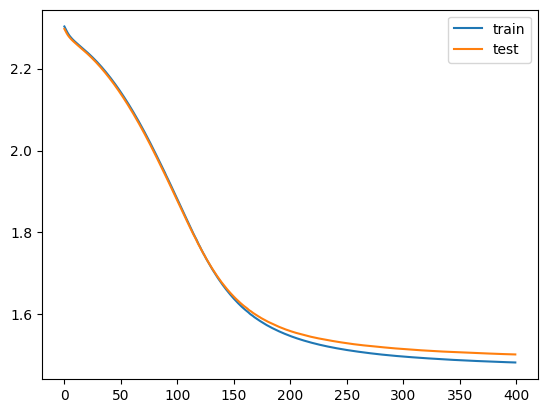

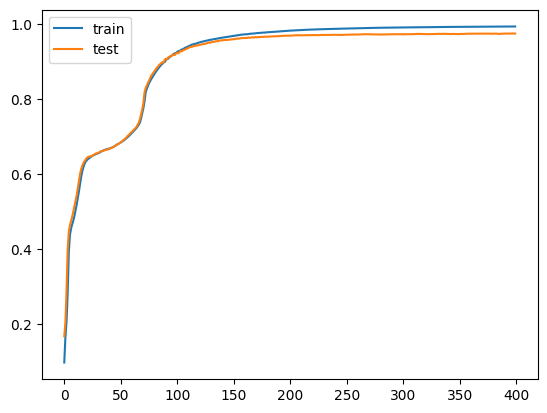

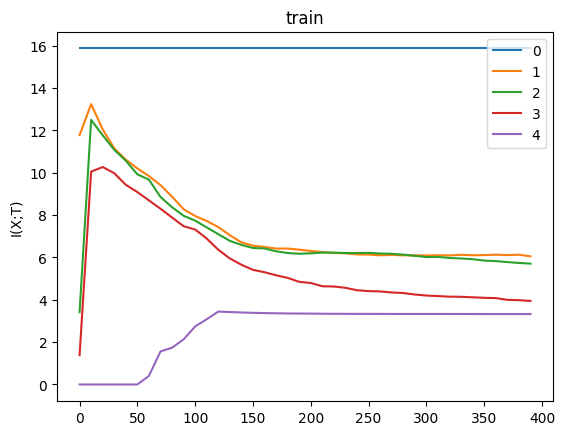

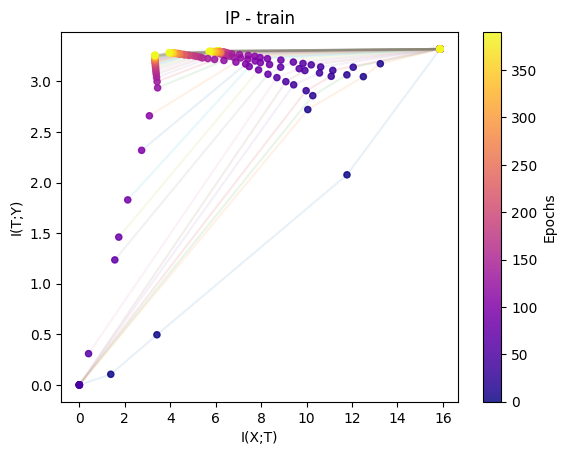

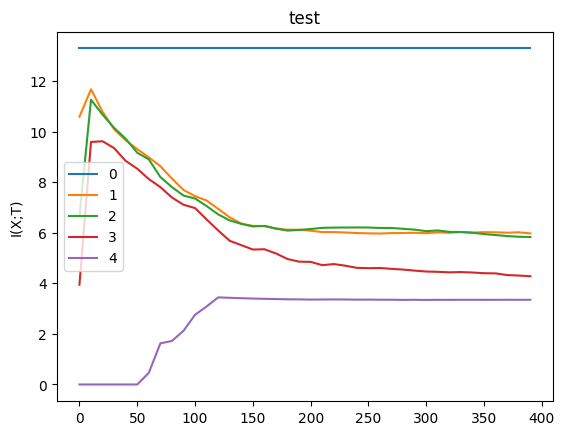

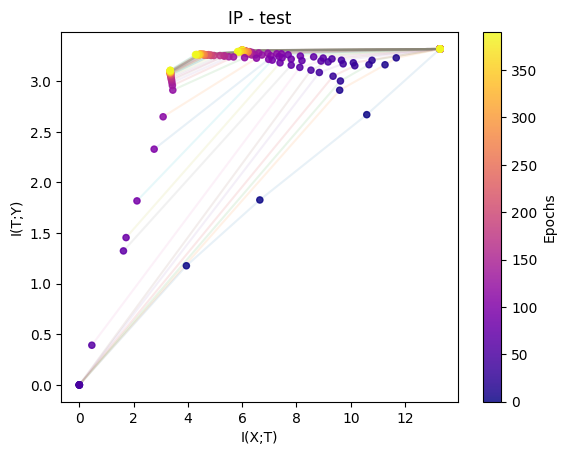

In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
from random import seed
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle

# 设置随机种子
np.random.seed(1234)
seed(1234)
torch.manual_seed(1234)

def get_unique_probs(x):
    uniqueids = np.ascontiguousarray(x).view(np.dtype((np.void, x.dtype.itemsize * x.shape[1])))
    _, unique_inverse, unique_counts = np.unique(uniqueids, return_index=False, return_inverse=True, return_counts=True)
    return np.asarray(unique_counts / float(sum(unique_counts))), unique_inverse

def bin_calc_information(labelixs, layerdata, binsize):
    nats2bits = 1.0 / np.log(2)

    def get_h(d):
        digitized = np.floor(d / binsize).astype('int')
        p_ts, _ = get_unique_probs(digitized)
        return -np.sum(p_ts * np.log(p_ts))

    H_LAYER = get_h(layerdata)
    H_LAYER_GIVEN_OUTPUT = 0
    for label, ixs in labelixs.items():
        h = get_h(layerdata[ixs])
        H_LAYER_GIVEN_OUTPUT += ixs.mean() * h
    return nats2bits * H_LAYER, nats2bits * (H_LAYER - H_LAYER_GIVEN_OUTPUT)

# 定义 MNIST 数据集类
class MNIST(datasets.MNIST):
    def __init__(self, root, train=True, download=False, randomize=False):
        super(MNIST, self).__init__(root, train, download=True)  # Ensure download is True
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.targets = self.targets.to(device)
        self.data = self.data / 255.0
        self.data = self.data.view(-1, 28 * 28).to(device)

        if randomize:
            idx_rnd = torch.randperm(len(self.targets))
            self.targets = self.targets[idx_rnd]

    def __getitem__(self, index):
        img, targets = self.data[index], self.targets[index]
        return img, targets

# 定义神经网络
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(784, 1024)
        self.fc2 = torch.nn.Linear(1024, 20)
        self.fc3 = torch.nn.Linear(20, 20)
        self.fc4 = torch.nn.Linear(20, 20)
        self.fc5 = torch.nn.Linear(20, 10)

    def forward(self, x):
        activations = []
        x = x.view(-1, 784)
        x = torch.tanh(self.fc1(x))
        activations.append(x.cpu().data.numpy())  # 将激活值移动到 CPU 上
        x = torch.tanh(self.fc2(x))
        activations.append(x.cpu().data.numpy())  # 将激活值移动到 CPU 上
        x = torch.tanh(self.fc3(x))
        activations.append(x.cpu().data.numpy())  # 将激活值移动到 CPU 上
        x = torch.tanh(self.fc4(x))
        activations.append(x.cpu().data.numpy())  # 将激活值移动到 CPU 上
        x = torch.softmax(self.fc5(x), dim=1)  # 添加dim参数以指定 softmax 在哪个维度上操作
        activations.append(x.cpu().data.numpy())  # 将激活值移动到 CPU 上
        return x, activations

# 定义训练和测试函数
def run_training(model, criterion, optimizer, loader, epochs=5000, mi_cycle=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    losses = {'train': [], 'test': []}
    accuracy = {'train': [], 'test': []}
    running_mis_xt = {'train': [], 'test': []}
    running_mis_ty = {'train': [], 'test': []}

    def get_class_masks(loader):
        samples_split = dict()
        for phase in ['train', 'test']:
            samples_split[phase] = {}
            classes = loader[phase].dataset.targets.cpu().detach().numpy()
            for i in range(10):
                samples_split[phase][i] = classes == i
        return samples_split

    class_masks = get_class_masks(loader)

    for i in range(epochs):
        for phase in ['train', 'test']:
            phase_loss = 0.0
            phase_labels = torch.tensor([], dtype=torch.long).to(device)
            phase_outputs = torch.tensor([]).to(device)

            for inputs, labels in loader[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs, activations = model(inputs)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                phase_loss += loss.item()
                phase_labels = torch.cat((phase_labels, labels))
                phase_outputs = torch.cat((phase_outputs, outputs))

            if i % mi_cycle == 0:
                running_mis_xt[phase].append([])
                running_mis_ty[phase].append([])
                # Get activations from the model
                activations = [torch.tensor(act) for act in activations]
                for j in range(len(activations)):
                    activity = activations[j].cpu().detach().numpy()
                    binxm, binym = bin_calc_information(class_masks[phase], activity, binsize=0.5)
                    running_mis_xt[phase][-1].append(binxm)
                    running_mis_ty[phase][-1].append(binym)

            n = float(len(loader[phase].dataset))
            loss = phase_loss / n
            acc = (phase_labels == phase_outputs.argmax(dim=1)).sum() / n
            accuracy[phase].append(float(acc))

            losses[phase].append(loss)
            print(f'Epoch {i:>4} {phase}: loss {loss:>.4f} - acc {acc:>.4f}')

    # 保存训练结果
    tracking = {
        'n_layers': len(activations),
        'mi_cycle': mi_cycle,
        'losses': losses,
        'accuracy': accuracy,
        'running_mis_xt': running_mis_xt,
        'running_mis_ty': running_mis_ty,
    }
    with open('train.pkl', 'wb') as f:
        pickle.dump(tracking, f)

    return tracking

# 绘图函数
def plot_results(tracking):
    def format_epochs(x, pos):
        return int(x * tracking['mi_cycle'])

    # 绘制损失
    plt.figure()
    for phase in ['train', 'test']:
        plt.plot(tracking['losses'][phase], label=phase)
    plt.legend()
    plt.savefig('losses.png')
    plt.show()

    # 绘制准确率
    plt.figure()
    for phase in ['train', 'test']:
        plt.plot(tracking['accuracy'][phase], label=phase)
    plt.legend()
    plt.savefig('acc.png')
    plt.show()

    # 绘制信息平面
    for phase in ['train', 'test']:
        running_mis_xt = np.array(tracking['running_mis_xt'][phase])
        running_mis_ty = np.array(tracking['running_mis_ty'][phase])

        fig, ax = plt.subplots()
        plt.title(phase)
        for i in range(tracking['n_layers']):
            plt.plot(running_mis_xt[:, i], label=f'{i}')
        plt.legend()
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_epochs))
        plt.ylabel('I(X;T)')
        plt.savefig(f'plot_{phase}.png')
        plt.show()

        plt.figure()
        plt.title(f'IP - {phase}')
        c = list(range(len(running_mis_xt[:, 0])))
        for j in range(tracking['n_layers']):
            plt.scatter(running_mis_xt[:, j], running_mis_ty[:, j], c=c, cmap='plasma', s=20, alpha=0.85, zorder=1)
        for j in range(len(running_mis_xt[:, 0])):
            plt.plot(running_mis_xt[j, :], running_mis_ty[j, :], alpha=0.1, zorder=0)

        cbar = plt.colorbar(format=ticker.FuncFormatter(format_epochs))
        cbar.set_label('Epochs')

        plt.xlabel('I(X;T)')
        plt.ylabel('I(T;Y)')
        plt.savefig(f'IP_{phase}.png')
        plt.show()

# 数据准备
data = dict()
data['train'] = MNIST('./dataset', train=True, download=True, randomize=False)
data['test'] = MNIST('./dataset', train=False, download=True)

loader = dict()
loader['train'] = DataLoader(data['train'], batch_size=60000, shuffle=False)
loader['test'] = DataLoader(data['test'], batch_size=10000, shuffle=False)

# 配置和训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'to device: {device}')
net = Net().to(device)

criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# 运行训练和测试
tracking = run_training(net, criterion, optimizer, loader, epochs=400, mi_cycle=10)

# 绘图
plot_results(tracking)


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
from random import seed
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle

# 设置随机种子
np.random.seed(1234)
seed(1234)
torch.manual_seed(1234)

def get_unique_probs(x):
    uniqueids = np.ascontiguousarray(x).view(np.dtype((np.void, x.dtype.itemsize * x.shape[1])))
    _, unique_inverse, unique_counts = np.unique(uniqueids, return_index=False, return_inverse=True, return_counts=True)
    return np.asarray(unique_counts / float(sum(unique_counts))), unique_inverse

def bin_calc_information(labelixs, layerdata, binsize):
    nats2bits = 1.0 / np.log(2)

    def get_h(d):
        digitized = np.floor(d / binsize).astype('int')
        p_ts, _ = get_unique_probs(digitized)
        return -np.sum(p_ts * np.log(p_ts))

    H_LAYER = get_h(layerdata)
    H_LAYER_GIVEN_OUTPUT = 0
    for label, ixs in labelixs.items():
        h = get_h(layerdata[ixs])
        H_LAYER_GIVEN_OUTPUT += ixs.mean() * h
    return nats2bits * H_LAYER, nats2bits * (H_LAYER - H_LAYER_GIVEN_OUTPUT)

# 定义 MNIST 数据集类
class MNIST(datasets.MNIST):
    def __init__(self, root, train=True, download=False, randomize=False):
        super(MNIST, self).__init__(root, train, download=True)  # Ensure download is True
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.targets = self.targets.to(device)
        self.data = self.data / 255.0
        self.data = self.data.view(-1, 28 * 28).to(device)

        if randomize:
            idx_rnd = torch.randperm(len(self.targets))
            self.targets = self.targets[idx_rnd]

    def __getitem__(self, index):
        img, targets = self.data[index], self.targets[index]
        return img, targets

# 定义神经网络
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(784, 1024)
        self.fc2 = torch.nn.Linear(1024, 20)
        self.fc3 = torch.nn.Linear(20, 20)
        self.fc4 = torch.nn.Linear(20, 20)
        self.fc5 = torch.nn.Linear(20, 10)

    def forward(self, x):
        activations = []
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        activations.append(x.cpu().data.numpy())  # 将激活值移动到 CPU 上
        x = torch.relu(self.fc2(x))
        activations.append(x.cpu().data.numpy())  # 将激活值移动到 CPU 上
        x = torch.relu(self.fc3(x))
        activations.append(x.cpu().data.numpy())  # 将激活值移动到 CPU 上
        x = torch.relu(self.fc4(x))
        activations.append(x.cpu().data.numpy())  # 将激活值移动到 CPU 上
        x = torch.softmax(self.fc5(x), dim=1)  # 添加dim参数以指定 softmax 在哪个维度上操作
        activations.append(x.cpu().data.numpy())  # 将激活值移动到 CPU 上
        return x, activations

# 定义训练和测试函数
def run_training(model, criterion, optimizer, loader, epochs=5000, mi_cycle=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    losses = {'train': [], 'test': []}
    accuracy = {'train': [], 'test': []}
    running_mis_xt = {'train': [], 'test': []}
    running_mis_ty = {'train': [], 'test': []}

    def get_class_masks(loader):
        samples_split = dict()
        for phase in ['train', 'test']:
            samples_split[phase] = {}
            classes = loader[phase].dataset.targets.cpu().detach().numpy()
            for i in range(10):
                samples_split[phase][i] = classes == i
        return samples_split

    class_masks = get_class_masks(loader)

    for i in range(epochs):
        for phase in ['train', 'test']:
            phase_loss = 0.0
            phase_labels = torch.tensor([], dtype=torch.long).to(device)
            phase_outputs = torch.tensor([]).to(device)

            for inputs, labels in loader[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs, activations = model(inputs)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                phase_loss += loss.item()
                phase_labels = torch.cat((phase_labels, labels))
                phase_outputs = torch.cat((phase_outputs, outputs))

            if i % mi_cycle == 0:
                running_mis_xt[phase].append([])
                running_mis_ty[phase].append([])
                # Get activations from the model
                activations = [torch.tensor(act) for act in activations]
                for j in range(len(activations)):
                    activity = activations[j].cpu().detach().numpy()
                    binxm, binym = bin_calc_information(class_masks[phase], activity, binsize=0.5)
                    running_mis_xt[phase][-1].append(binxm)
                    running_mis_ty[phase][-1].append(binym)

            n = float(len(loader[phase].dataset))
            loss = phase_loss / n
            acc = (phase_labels == phase_outputs.argmax(dim=1)).sum() / n
            accuracy[phase].append(float(acc))

            losses[phase].append(loss)
            print(f'Epoch {i:>4} {phase}: loss {loss:>.4f} - acc {acc:>.4f}')

    # 保存训练结果
    tracking = {
        'n_layers': len(activations),
        'mi_cycle': mi_cycle,
        'losses': losses,
        'accuracy': accuracy,
        'running_mis_xt': running_mis_xt,
        'running_mis_ty': running_mis_ty,
    }
    with open('train.pkl', 'wb') as f:
        pickle.dump(tracking, f)

    return tracking

# 绘图函数
def plot_results(tracking):
    def format_epochs(x, pos):
        return int(x * tracking['mi_cycle'])

    # 绘制损失
    plt.figure()
    for phase in ['train', 'test']:
        plt.plot(tracking['losses'][phase], label=phase)
    plt.legend()
    plt.savefig('losses.png')
    plt.show()

    # 绘制准确率
    plt.figure()
    for phase in ['train', 'test']:
        plt.plot(tracking['accuracy'][phase], label=phase)
    plt.legend()
    plt.savefig('acc.png')
    plt.show()

    # 绘制信息平面
    for phase in ['train', 'test']:
        running_mis_xt = np.array(tracking['running_mis_xt'][phase])
        running_mis_ty = np.array(tracking['running_mis_ty'][phase])

        fig, ax = plt.subplots()
        plt.title(phase)
        for i in range(tracking['n_layers']):
            plt.plot(running_mis_xt[:, i], label=f'{i}')
        plt.legend()
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_epochs))
        plt.ylabel('I(X;T)')
        plt.savefig(f'plot_{phase}.png')
        plt.show()

        plt.figure()
        plt.title(f'IP - {phase}')
        c = list(range(len(running_mis_xt[:, 0])))
        for j in range(tracking['n_layers']):
            plt.scatter(running_mis_xt[:, j], running_mis_ty[:, j], c=c, cmap='plasma', s=20, alpha=0.85, zorder=1)
        for j in range(len(running_mis_xt[:, 0])):
            plt.plot(running_mis_xt[j, :], running_mis_ty[j, :], alpha=0.1, zorder=0)

        cbar = plt.colorbar(format=ticker.FuncFormatter(format_epochs))
        cbar.set_label('Epochs')

        plt.xlabel('I(X;T)')
        plt.ylabel('I(T;Y)')
        plt.savefig(f'IP_{phase}.png')
        plt.show()

# 数据准备
data = dict()
data['train'] = MNIST('./dataset', train=True, download=True, randomize=False)
data['test'] = MNIST('./dataset', train=False, download=True)

loader = dict()
loader['train'] = DataLoader(data['train'], batch_size=60000, shuffle=False)
loader['test'] = DataLoader(data['test'], batch_size=10000, shuffle=False)

# 配置和训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'to device: {device}')
net = Net().to(device)

criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# 运行训练和测试
tracking = run_training(net, criterion, optimizer, loader, epochs=400, mi_cycle=10)

# 绘图
plot_results(tracking)

to device: cuda
Epoch    0 train: loss 2.3025 - acc 0.0975
Epoch    0 test: loss 2.3016 - acc 0.0977
Epoch    1 train: loss 2.3017 - acc 0.0979
Epoch    1 test: loss 2.3008 - acc 0.1569
Epoch    2 train: loss 2.3008 - acc 0.1582
Epoch    2 test: loss 2.2998 - acc 0.1491
Epoch    3 train: loss 2.2998 - acc 0.1543
Epoch    3 test: loss 2.2986 - acc 0.1884
Epoch    4 train: loss 2.2986 - acc 0.1946
Epoch    4 test: loss 2.2970 - acc 0.2036
Epoch    5 train: loss 2.2970 - acc 0.2070
Epoch    5 test: loss 2.2949 - acc 0.2032
Epoch    6 train: loss 2.2950 - acc 0.2067
Epoch    6 test: loss 2.2925 - acc 0.2073
Epoch    7 train: loss 2.2925 - acc 0.2098
Epoch    7 test: loss 2.2895 - acc 0.2148
Epoch    8 train: loss 2.2896 - acc 0.2158
Epoch    8 test: loss 2.2857 - acc 0.2359
Epoch    9 train: loss 2.2859 - acc 0.2329
Epoch    9 test: loss 2.2811 - acc 0.2774
Epoch   10 train: loss 2.2813 - acc 0.2759
Epoch   10 test: loss 2.2756 - acc 0.3222
Epoch   11 train: loss 2.2758 - acc 0.3205
Epoch 